# Generating Buy/Sell/Hold signals

Importing libraries.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow_docs as tfdocs
from keras.optimizers import adam
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler


We import a random company and generate it's signals

In [17]:
inputs = pd.read_csv('M3 temp/MCB PA Equity.csv')
inputs = inputs.rename(columns={"14 RSI": "RSI"})
inputs.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,21 SMA,50 SMA,100 SMA,...,52-week low,21-avg volume,First Resistance,Second Resistance,Third Resistance,First Support,Second Support,Third Support,Score,Predicted Price
0,3754,5/25/2015,175.0121,175.0121,166.7204,166.7204,514400,178.402186,174.013834,188.100522,...,153.9058,210390.4762,172.248200,177.776000,180.539900,163.956500,161.192600,155.664800,-0.090909,175.63486
1,3755,5/26/2015,168.3918,168.3918,162.5581,163.4233,212000,177.079995,173.690946,187.732351,...,153.9058,225590.4762,167.024033,170.624767,172.857733,161.190333,158.957367,155.356633,-1.000000,172.41557
2,3756,5/27/2015,163.2136,168.2542,165.2128,166.6810,218200,176.109267,173.472410,187.334091,...,153.9058,200733.3333,168.219200,169.757400,171.260600,165.177800,163.674600,162.136400,0.000000,170.00098
3,3757,5/28/2015,166.1698,168.0641,166.1632,167.7757,47600,175.323009,173.363078,186.968355,...,153.9058,166595.2381,168.505467,169.235233,170.406367,166.604567,165.433433,164.703667,0.000000,168.06651
4,3758,5/29/2015,167.8347,176.1592,167.8019,176.0216,479500,175.081424,173.591840,186.719060,...,153.9058,141085.7143,178.853233,181.684867,187.210533,170.495933,164.970267,162.138633,1.000000,167.41870


In [18]:
inputs.describe()

,Unnamed: 0,Open,High,Low,Close,Volume,21 SMA,50 SMA,100 SMA,200 SMA,...,52-week low,21-avg volume,First Resistance,Second Resistance,Third Resistance,First Support,Second Support,Third Support,Score,Predicted Price
count,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1.404000e+03,1404.000000,1404.000000,1404.000000,1404.000000,...,1404.000000,1.404000e+03,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000
mean,4455.500000,165.418949,167.348372,163.277293,165.184067,5.963544e+05,165.193302,165.211566,165.467193,166.492411,...,141.381133,5.942470e+05,167.262528,169.340989,171.333607,163.191450,161.198832,159.120371,0.008729,165.540261
std,405.444201,14.018414,14.046863,13.832229,13.958725,7.002335e+05,12.914198,11.714658,9.970650,8.208864,...,8.645599,3.469954e+05,14.073842,14.288694,14.624031,13.860478,13.864443,13.999347,0.609818,13.779839
min,3754.000000,126.395200,131.528400,126.104600,128.710000,1.430000e+02,135.544319,137.164696,141.229956,148.609403,...,128.710000,1.410857e+05,131.272033,131.922167,132.315933,124.713133,119.718667,113.332733,-1.000000,131.711730
25%,4104.750000,156.783500,158.905125,154.755250,156.606500,2.108500e+05,157.909354,157.803054,158.888006,163.147779,...,130.621900,3.676940e+05,158.718983,160.715033,162.283558,154.776317,152.691483,150.066658,-0.500000,157.086038
50%,4455.500000,164.663900,166.310100,162.902300,164.574600,3.927000e+05,164.352771,165.859002,167.139823,167.620439,...,145.635100,5.083238e+05,166.236383,168.296883,170.213183,162.800900,160.942500,158.850717,0.000000,164.957035
75%,4806.250000,173.581575,175.219950,171.500000,173.161600,7.227000e+05,172.773156,172.357459,171.505733,170.274311,...,149.615100,7.209690e+05,175.246208,177.362592,179.532708,171.533217,169.648542,167.872533,0.538462,173.527347
max,5157.000000,211.217500,212.877400,209.425500,211.651300,1.171720e+07,206.786957,201.980324,192.733466,185.872419,...,155.131100,2.517467e+06,213.855100,216.058900,219.240400,209.224333,207.781367,206.184333,1.000000,211.489600


We preprocess the data by changing data types and doing some feature engineering.

In [19]:
def correct_dtype(inputs):

    inputs['Close'] = pd.to_numeric(inputs['Close'])
    inputs['Score'] = pd.to_numeric(inputs['Score'])
    
    return inputs

inputs = correct_dtype(inputs)
inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1404 non-null   int64  
 1   Date               1404 non-null   object 
 2   Open               1404 non-null   float64
 3   High               1404 non-null   float64
 4   Low                1404 non-null   float64
 5   Close              1404 non-null   float64
 6   Volume             1404 non-null   int64  
 7   21 SMA             1404 non-null   float64
 8   50 SMA             1404 non-null   float64
 9   100 SMA            1404 non-null   float64
 10  200 SMA            1404 non-null   float64
 11  RSI                1404 non-null   float64
 12  Upper BBand        1404 non-null   float64
 13  Middle BBand       1404 non-null   float64
 14  Lower BBand        1404 non-null   float64
 15  MACD               1404 non-null   float64
 16  MACD Signal        1404 

In [20]:
def difference(inputs):

    temp = inputs['Close'].diff()
    #print(temp.head())
    temp = temp[1:]
    #print(temp.head())

    inputs['Label'] = temp
    
    temp = inputs['Predicted Price'].diff()
    #print(temp.head())
    temp = temp[1:]
    #print(temp.head())

    inputs['Diff'] = temp
    
    temp = inputs['RSI'].diff()
    #print(temp.head())
    temp = temp[1:]
    #print(temp.head())

    inputs['RSI change'] = temp
    
    temp = inputs['21 SMA'].diff()
    #print(temp.head())
    temp = temp[1:]
    #print(temp.head())

    inputs['21 SMA change'] = temp
    
    return inputs

inputs = difference(inputs)
inputs.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,21 SMA,50 SMA,100 SMA,...,Third Resistance,First Support,Second Support,Third Support,Score,Predicted Price,Label,Diff,RSI change,21 SMA change
0,3754,5/25/2015,175.0121,175.0121,166.7204,166.7204,514400,178.402186,174.013834,188.100522,...,180.539900,163.956500,161.192600,155.664800,-0.090909,175.63486,NaN,NaN,NaN,NaN
1,3755,5/26/2015,168.3918,168.3918,162.5581,163.4233,212000,177.079995,173.690946,187.732351,...,172.857733,161.190333,158.957367,155.356633,-1.000000,172.41557,-3.2971,-3.21929,-3.177357,-1.322191
2,3756,5/27/2015,163.2136,168.2542,165.2128,166.6810,218200,176.109267,173.472410,187.334091,...,171.260600,165.177800,163.674600,162.136400,0.000000,170.00098,3.2577,-2.41459,5.963553,-0.970729
3,3757,5/28/2015,166.1698,168.0641,166.1632,167.7757,47600,175.323009,173.363078,186.968355,...,170.406367,166.604567,165.433433,164.703667,0.000000,168.06651,1.0947,-1.93447,1.908300,-0.786257
4,3758,5/29/2015,167.8347,176.1592,167.8019,176.0216,479500,175.081424,173.591840,186.719060,...,187.210533,170.495933,164.970267,162.138633,1.000000,167.41870,8.2459,-0.64781,12.007850,-0.241586


In [21]:
def labelling(inputs):

    mean = inputs['Label'].mean()
    std = inputs['Label'].std()

    #print('Mean = ', mean)
    #print('Std = ', std)
    #print('Pos Scaled = ', (mean+std)*0.3)
    #print('Neg Scaled = ', (mean-std)*0.3)

    for i in range(len(inputs)):

        x = inputs['Label'][i]

        if x > (mean + std)*0.3:

            inputs['Label'][i] = 1

        elif x < (mean - std)*0.3:

            inputs['Label'][i] = -1

        else:

            inputs['Label'][i] = 0
            
    mean = inputs['Diff'].mean()
    std = inputs['Diff'].std()

    #print('Mean = ', mean)
    #print('Std = ', std)
    #print('Pos Scaled = ', (mean+std)*0.3)
    #print('Neg Scaled = ', (mean-std)*0.3)

    for i in range(len(inputs)):

        x = inputs['Diff'][i]

        if x > (mean + std)*0.3:

            inputs['Diff'][i] = 1

        elif x < (mean - std)*0.3:

            inputs['Diff'][i] = -1

        else:

            inputs['Diff'][i] = 0
            
    mean = inputs['Score'].mean()
    std = inputs['Score'].std()

    #print('Mean = ', mean)
    #print('Std = ', std)
    #print('Pos Scaled = ', (mean+std)*0.3)
    #print('Neg Scaled = ', (mean-std)*0.3)

    for i in range(len(inputs)):

        x = inputs['Score'][i]

        if x > (mean + std)*0.3:

            inputs['Score'][i] = 1

        elif x < (mean - std)*0.3:

            inputs['Score'][i] = -1

        else:

            inputs['Score'][i] = 0
            
        return inputs
            
inputs = labelling(inputs)

C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying 

In [22]:
inputs.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,21 SMA,50 SMA,100 SMA,...,Third Resistance,First Support,Second Support,Third Support,Score,Predicted Price,Label,Diff,RSI change,21 SMA change
1399,5153,10/2/2020,176.90,178.00,173.25,175.71,299223,176.220000,175.9516,167.1970,...,182.806667,173.306667,170.903333,168.556667,-0.583333,174.38283,-1.0,-1.0,-3.470454,0.094286
1400,5154,10/5/2020,175.50,177.00,170.71,172.58,411284,176.218571,175.9194,167.4303,...,182.440000,169.860000,167.140000,163.570000,-0.095238,176.19630,-1.0,1.0,-7.165204,-0.001429
1401,5155,10/6/2020,173.49,174.49,170.10,171.74,260037,176.126667,175.8138,167.6530,...,178.510000,169.730000,167.720000,165.340000,0.050000,175.16805,-1.0,-1.0,-1.705988,-0.091905
1402,5156,10/7/2020,174.90,175.99,171.70,174.64,369952,176.301905,175.7614,167.9010,...,180.810000,172.230000,169.820000,167.940000,0.500000,172.90756,1.0,-1.0,7.494411,0.175238
1403,5157,10/8/2020,176.90,176.90,173.10,175.44,852960,176.466191,175.7222,168.1657,...,180.993333,173.393333,171.346667,169.593333,0.000000,175.75190,0.0,1.0,1.870175,0.164286


In [23]:
inputs.describe()

,Unnamed: 0,Open,High,Low,Close,Volume,21 SMA,50 SMA,100 SMA,200 SMA,...,Third Resistance,First Support,Second Support,Third Support,Score,Predicted Price,Label,Diff,RSI change,21 SMA change
count,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1.404000e+03,1404.000000,1404.000000,1404.000000,1404.000000,...,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1403.000000,1403.000000
mean,4455.500000,165.418949,167.348372,163.277293,165.184067,5.963544e+05,165.193302,165.211566,165.467193,166.492411,...,171.333607,163.191450,161.198832,159.120371,0.008793,165.540261,-0.012821,-0.029202,0.011170,-0.001380
std,405.444201,14.018414,14.046863,13.832229,13.958725,7.002335e+05,12.914198,11.714658,9.970650,8.208864,...,14.624031,13.860478,13.864443,13.999347,0.609812,13.779839,0.793671,0.860888,4.773539,0.579646
min,3754.000000,126.395200,131.528400,126.104600,128.710000,1.430000e+02,135.544319,137.164696,141.229956,148.609403,...,132.315933,124.713133,119.718667,113.332733,-1.000000,131.711730,-1.000000,-1.000000,-17.787235,-2.793029
25%,4104.750000,156.783500,158.905125,154.755250,156.606500,2.108500e+05,157.909354,157.803054,158.888006,163.147779,...,162.283558,154.776317,152.691483,150.066658,-0.500000,157.086038,-1.000000,-1.000000,-2.699183,-0.340579
50%,4455.500000,164.663900,166.310100,162.902300,164.574600,3.927000e+05,164.352771,165.859002,167.139823,167.620439,...,170.213183,162.800900,160.942500,158.850717,0.000000,164.957035,0.000000,0.000000,0.000000,0.004476
75%,4806.250000,173.581575,175.219950,171.500000,173.161600,7.227000e+05,172.773156,172.357459,171.505733,170.274311,...,179.532708,171.533217,169.648542,167.872533,0.538462,173.527347,1.000000,1.000000,2.390727,0.338683
max,5157.000000,211.217500,212.877400,209.425500,211.651300,1.171720e+07,206.786957,201.980324,192.733466,185.872419,...,219.240400,209.224333,207.781367,206.184333,1.000000,211.489600,1.000000,1.000000,24.920751,1.611881


In [24]:
def final_df(inputs):

    new_inputs = pd.DataFrame(columns = ['Price', 'Score','RSI', '21 SMA', 'MACD', 'MACD Signal', 'Label'])
    new_inputs['Price'] = inputs['Diff']
    new_inputs['Score'] = inputs['Score']
    new_inputs['RSI'] = inputs['RSI change']
    new_inputs['21 SMA'] = inputs['21 SMA change']
    new_inputs['MACD'] = inputs['MACD']
    new_inputs['MACD Signal'] = inputs['MACD Signal']
    new_inputs['Label'] = inputs['Label']
    
    new_inputs = new_inputs.iloc[1:]
    return new_inputs

new_inputs = final_df(inputs)
new_inputs.head()


,Price,Score,RSI,21 SMA,MACD,MACD Signal,Label
1,-1.0,-1.000000,-3.177357,-1.322191,-2.496463,-1.050524,-1.0
2,-1.0,0.000000,5.963553,-0.970729,-2.818106,-1.404041,1.0
3,-1.0,0.000000,1.908300,-0.786257,-2.950664,-1.713366,1.0
4,0.0,1.000000,12.007850,-0.241586,-2.363102,-1.843313,1.0
5,1.0,-0.894737,0.082067,-0.238467,-1.870606,-1.848771,0.0


We have a final dataframe ready for preperation of inputs.

Positive: 433 , Negative: 451 , Neutral: 519


Text(0.5, 1.0, 'Sentiment Data Distribution')

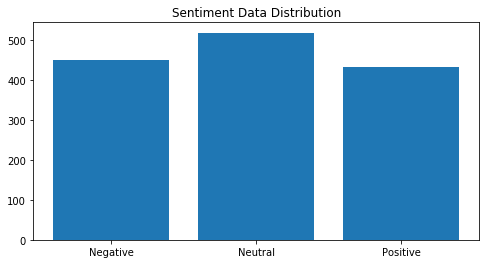

In [25]:
plt.figure(figsize=(8,4))
count_pos = new_inputs['Label'].value_counts()[1]
count_ntl = new_inputs['Label'].value_counts()[0]
count_neg = new_inputs['Label'].value_counts()[-1]

print('Positive:', count_pos, ',', 'Negative:', count_neg, ',', 'Neutral:', count_ntl)

plt.bar(['Negative', 'Neutral', 'Positive'], [count_neg, count_ntl, count_pos])
plt.title("Sentiment Data Distribution")

In [26]:
def split(new_inputs):

    train_data = new_inputs[:int(len(new_inputs)*0.7)]
    test_data = new_inputs[int(len(new_inputs)*0.7):int(len(new_inputs)*0.8)]
    val_data = new_inputs[int(len(new_inputs)*0.8):]

    #Convert to ndarray
    
    train_data = np.asarray(train_data)
    test_data = np.asarray(test_data)
    val_data = np.asarray(val_data)


    return train_data, test_data, val_data

train_data, test_data, val_data = split(new_inputs)
print(train_data[0])
print(test_data.shape[0])
print(val_data.shape[0])

[-1.         -1.         -3.17735737 -1.3221905  -2.49646332 -1.05052439
 -1.        ]
140
281


In [27]:
def data_prep(train_data):
    
    x_train = []
    y_train = []

    for i in range(train_data.shape[0]):

        x_train.append(train_data[i][:6])
        y_train.append(train_data[i][6:])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)

    return x_train, y_train

x_train, y_train = data_prep(train_data)
x_test, y_test = data_prep(test_data)
x_val, y_val = data_prep(val_data)

y_test[:10]

array([[-1.],
       [ 0.],
       [-1.],
       [-1.],
       [-1.],
       [ 0.],
       [-1.],
       [ 0.],
       [-1.],
       [ 0.]])

In [28]:
def label_encoding(y_train, y_test, y_val):

    from keras.utils.np_utils import to_categorical
    y_train = to_categorical(y_train, num_classes=3)
    y_test = to_categorical(y_test, num_classes=3)
    y_val = to_categorical(y_val, num_classes=3)
    
    return y_train, y_test, y_val

y_train, y_test, y_val = label_encoding(y_train, y_test, y_val)
#labels = np.argmax(labels, axis=1)
#print(y_train[:10])
#print(y_test[:10])

In [29]:
#y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)

print("x_train shape:", x_train.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_test)

x_train shape: (982, 6)
y_train shape: (982, 3)
y_test shape: (140, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 

We now make the model for training.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 755
Trainable params: 755
Non-trainable params: 0
_________________________________________________________________


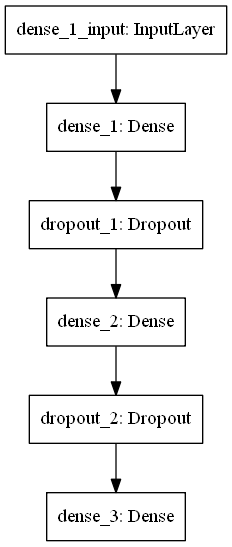

In [30]:
import keras
from keras.models import Sequential
from keras.layers import Dense

def create_model(x_train, units_1, units_2):
    
    # Neural network
    model = Sequential()
    model.add(Dense(16, input_dim=6, activation= 'relu', kernel_initializer='glorot_uniform',))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(16, activation= 'relu'))
    model.add(Dense(3, activation= 'softmax'))

    return model
    
    
model = create_model(x_train, 16, 32)

model.summary()

plot_model(model, to_file='model.png')

In [31]:
def compile_model(model, x_train, y_train, x_test, y_test):
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['acc'])
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data = (x_test, y_test), verbose = 0, )
    return history

history = compile_model(model, x_train, y_train, x_test, y_test)

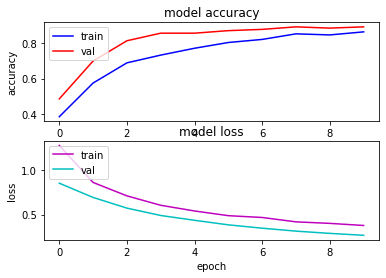

In [32]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['acc'], c= 'b')
at.plot(history.history['val_acc'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['train', 'val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [33]:
def decode_sentiment(score):
    if score[0] > score[1] and score[0] > score[2]:
        #print(score[0], '0\n---')
        return 0
    elif score[1] > score[0] and score[1] > score[2]:
        #print(score[1], '1\n---')
        return 1
    elif score[2] > score[0] and score[2] > score[1]:
        #print(score[2], '-1\n---')
        return -1

scores = model.predict(x_test, verbose=1, batch_size=10)
y_pred_1d = [decode_sentiment(score) for score in scores]
temp = [decode_sentiment(score) for score in y_test]

140/140 [==============================] - 0s 901us/step


In [34]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

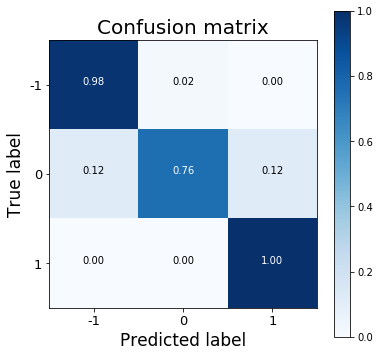

In [35]:
cnf_matrix = confusion_matrix(temp, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=[-1, 0, 1], title="Confusion matrix")
plt.show()

In [36]:
print(classification_report(list(temp), y_pred_1d))

              precision    recall  f1-score   support

          -1       0.87      0.98      0.92        49
           0       0.98      0.76      0.85        58
           1       0.82      1.00      0.90        33

    accuracy                           0.89       140
   macro avg       0.89      0.91      0.89       140
weighted avg       0.90      0.89      0.89       140



In [38]:
output = inputs[int(len(new_inputs)*0.7):]
output.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,21 SMA,50 SMA,100 SMA,...,Third Resistance,First Support,Second Support,Third Support,Score,Predicted Price,Label,Diff,RSI change,21 SMA change
982,4736,2/27/2019,180.0961,180.1047,173.2107,177.7004,448800,178.895390,173.090444,169.605059,...,187.693833,173.905833,170.111267,167.011833,0.666667,181.30220,-1.0,0.0,-7.003729,-0.069762
983,4737,2/28/2019,177.5281,179.6738,174.9342,176.7698,502200,178.739457,173.202472,169.744354,...,184.057267,174.578067,172.386333,169.838467,-1.000000,181.65106,-1.0,0.0,-2.356751,-0.155933
984,4738,3/1/2019,176.0200,179.1568,175.7960,177.5367,703600,178.665181,173.396536,169.940300,...,182.557800,175.836200,174.135700,172.475400,-0.857143,178.54688,0.0,-1.0,2.009592,-0.074276
985,4739,3/4/2019,177.9417,179.2343,174.7188,175.0635,507300,178.407476,173.550616,170.172404,...,182.474433,173.443433,171.823367,168.927933,-0.083333,177.71815,-1.0,-1.0,-6.099691,-0.257705
986,4740,3/5/2019,175.7960,176.4768,174.0725,174.1414,446500,178.074676,173.686254,170.415049,...,178.125600,173.317000,172.492600,170.912700,0.333333,178.65930,-1.0,1.0,-2.056152,-0.332800


In [39]:
scores = model.predict(x_test, verbose=1, batch_size=10)
x = [decode_sentiment(score) for score in scores]

scores = model.predict(x_val, verbose=1, batch_size=10)
y = [decode_sentiment(score) for score in scores]


pred = np.concatenate((x, y))

output = output.iloc[1:]

output['Pred'] = pred
output.tail(10)


281/281 [==============================] - 0s 69us/step


,Unnamed: 0,Date,Open,High,Low,Close,Volume,21 SMA,50 SMA,100 SMA,...,First Support,Second Support,Third Support,Score,Predicted Price,Label,Diff,RSI change,21 SMA change,Pred
1394,5148,9/25/2020,176.99,178.00,175.25,176.70,371414,175.497143,175.1946,166.120859,...,175.300000,173.900000,172.550000,-0.333333,178.62714,-1.0,1.0,-2.452571,0.142857,-1
1395,5149,9/28/2020,177.99,177.99,172.01,174.31,407701,175.616191,175.3790,166.353900,...,171.550000,168.790000,165.570000,0.555556,177.25554,-1.0,-1.0,-6.600793,0.119048,-1
1396,5150,9/29/2020,172.53,178.00,172.53,175.13,448789,175.809524,175.5738,166.565600,...,172.440000,169.750000,166.970000,-0.400000,175.62607,1.0,-1.0,2.364103,0.193333,1
1397,5151,9/30/2020,175.13,176.50,172.99,173.82,292158,175.890476,175.7088,166.749500,...,172.373333,170.926667,168.863333,0.733333,177.05559,-1.0,1.0,-3.430186,0.080952,-1
1398,5152,10/1/2020,175.69,178.00,172.11,177.02,283819,176.125714,175.8696,166.968200,...,173.420000,169.820000,167.530000,0.541667,175.07462,1.0,-1.0,8.557668,0.235238,1
1399,5153,10/2/2020,176.90,178.00,173.25,175.71,299223,176.220000,175.9516,167.197000,...,173.306667,170.903333,168.556667,-0.583333,174.38283,-1.0,-1.0,-3.470454,0.094286,-1
1400,5154,10/5/2020,175.50,177.00,170.71,172.58,411284,176.218571,175.9194,167.430300,...,169.860000,167.140000,163.570000,-0.095238,176.19630,-1.0,1.0,-7.165204,-0.001429,-1
1401,5155,10/6/2020,173.49,174.49,170.10,171.74,260037,176.126667,175.8138,167.653000,...,169.730000,167.720000,165.340000,0.050000,175.16805,-1.0,-1.0,-1.705988,-0.091905,-1
1402,5156,10/7/2020,174.90,175.99,171.70,174.64,369952,176.301905,175.7614,167.901000,...,172.230000,169.820000,167.940000,0.500000,172.90756,1.0,-1.0,7.494411,0.175238,1
1403,5157,10/8/2020,176.90,176.90,173.10,175.44,852960,176.466191,175.7222,168.165700,...,173.393333,171.346667,169.593333,0.000000,175.75190,0.0,1.0,1.870175,0.164286,1


In [40]:
output.to_csv('Updated-Predictions.csv')

In [41]:
temp = pd.read_csv('M3 temp/ABOT PA Equity.csv')
temp = temp.rename(columns={"14 RSI": "RSI"})
temp.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,21 SMA,50 SMA,100 SMA,...,52-week low,21-avg volume,First Resistance,Second Resistance,Third Resistance,First Support,Second Support,Third Support,Score,Predicted Price
0,3651,12/31/2014,541.3967,571.7852,541.3967,568.3305,27300,615.060043,580.191370,518.990793,...,283.5191,51504.76190,579.611567,590.892633,610.000067,549.223067,530.115633,518.834567,-1.000000,602.21670
1,3652,1/1/2015,559.7898,562.5887,555.7913,560.4615,3550,608.317433,581.931676,520.479246,...,283.5191,51100.00000,563.436367,566.411233,570.233767,556.638967,552.816433,549.841567,1.000000,577.81810
2,3653,1/2/2015,564.5880,583.3809,560.1896,579.0225,18950,602.747333,583.867748,522.108941,...,283.5191,49854.76190,588.205733,597.388967,611.397033,565.014433,551.006367,541.823133,1.000000,587.77870
3,3654,1/5/2015,572.5050,581.7815,571.7852,573.3127,1350,596.952938,585.810378,523.723283,...,283.5191,47985.71429,579.467733,585.622767,589.464033,569.471433,565.630167,559.475133,0.000000,574.96204
4,3655,1/6/2015,566.1074,566.1074,557.3907,559.9417,8850,591.197386,587.600426,525.348152,...,283.5191,44733.33333,564.902500,569.863300,573.619200,556.185800,552.429900,547.469100,0.333333,571.16700


## Run on 100 companies

In [43]:
KSE100 = pd.read_csv('KSE100.csv')
KSE100 = ['MCB PA Equity', 'PPL PA Equity', 'PSO PA Equity', 'ABOT PA Equity', 'LUCK PA Equity']

for i in range(len(KSE100)):
    
    name = KSE100[i]
    print(name)
    inputs = pd.read_csv('M3 temp/' + name + '.csv')
    inputs = inputs.rename(columns={"14 RSI": "RSI"})
    inputs = correct_dtype(inputs)
    inputs = difference(inputs)
    inputs = labelling(inputs)
    new_inputs = final_df(inputs)
    
    train_data, test_data, val_data = split(new_inputs)
    x_train, y_train = data_prep(train_data)
    x_test, y_test = data_prep(test_data)
    x_val, y_val = data_prep(val_data)
    y_train, y_test, y_val = label_encoding(y_train, y_test, y_val)
    
    model = create_model(x_train, 16, 32)
    history = compile_model(model, x_train, y_train, x_test, y_test)
    model.save('M3 Saved Models/' + name + '.h5')
    model = tf.keras.models.load_model('M3 Saved Models/' + name + '.h5')
    
    output = inputs[int(len(new_inputs)*0.7):]
    
    scores = model.predict(x_test, verbose=1, batch_size=10)
    x = [decode_sentiment(score) for score in scores]

    scores = model.predict(x_val, verbose=1, batch_size=10)
    y = [decode_sentiment(score) for score in scores]
    
    pred = np.concatenate((x, y))

    output = output.iloc[1:]

    output['Pred'] = pred
    
    output.to_csv('M3 Output/' + name + '.csv')
    

MCB PA Equity


C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying 

281/281 [==============================] - 0s 171us/sample
PPL PA Equity


C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying 

247/247 [==============================] - 0s 224us/sample
PSO PA Equity


C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying 

298/298 [==============================] - 0s 131us/sample
ABOT PA Equity


C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying 

302/302 [==============================] - 0s 139us/sample
LUCK PA Equity


C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying 

302/302 [==============================] - 0s 142us/sample
